# Fe3+/Fe2+ model errors

This notebook shows the procedure we used to estimate errors on melt Fe3+/Fe2+ models. We use a validation dataset with measured melt Fe3+/Fe2+ ratios to estimate the accuracy and precision of the models included in MagmaPandas. The dataset can be downloaded [here](https://github.com/TDGerve/MagmaPandas/blob/main/src/MagmaPandas/model_calibrations/data/Fe3Fe2_calibration_data.csv)

In [1]:
import pandas as pd
import numpy as np
from scipy import optimize as opt
from scipy.interpolate import splrep, splev
from IPython.display import clear_output

import MagmaPandas as mp
import MagmaPandas.Fe_redox.Fe3Fe2_models as fe
from MagmaPandas.tools.model_errors import _error_func, _running_stddev

import matplotlib.pyplot as plt

Read the validation dataset and remove compositions not relevant for igneous petrology.

In [2]:
slags = ["KC1989", "K2000", "HI2007"]
hydrous = ["G2002", "G2003", "Bc2005"]
simplified_compositions = ["M2006"]#"BM2010"
inaccuracte_fO2 = ["SB2008"]

exclude = slags + simplified_compositions + inaccuracte_fO2

data = pd.read_csv("../../../src/MagmaPandas/model_calibrations/data/Fe3Fe2_calibration_data.csv")
data = data.replace([np.inf, -np.inf], np.nan)
data = data.query("ref not in @exclude")

Prepare data needed to run the models

In [3]:
models = mp.Fe3Fe2_models
results = {}

melts = mp.Melt(data, units="wt.%", datatype="oxide")
melts = melts[melts.elements]
melts.recalculate(inplace=True)

T_K = data["T_K"]
P_bar = data["P_bar"]
fO2 = data["fO2"]

These are all the models we are going to test, except for *fixed*.

In [4]:
print("\n".join(models))

armstrong2019
borisov2018
deng2020
fixed
hirschmann2022
jayasuriya2004
kress_carmichael1991
oneill2006
oneill2018
putirka2016_6b
putirka2016_6c
sun2024
zhang2017


Calculate Fe3Fe2 for the validation dataset with all models

In [5]:
for i, m in enumerate(models):

    if m == "fixed":
        continue
    model = getattr(fe, m)

    clear_output()
    print(f"model: {m}\n{i+1:03}/{len(models):03}")

    Fe3Fe2 = data[["ref", "run", "P_bar", "T_K", "fO2", "_Fe3Fe2",]].copy()
    Fe3Fe2["_Fe3Fe2_model"] = model.calculate_Fe3Fe2(melt_mol_fractions=melts.moles(), P_bar=P_bar, T_K=T_K, fO2=fO2)
    Fe3Fe2["delta"] = Fe3Fe2["_Fe3Fe2_model"] -Fe3Fe2["_Fe3Fe2"]
    Fe3Fe2 = Fe3Fe2.sort_values("_Fe3Fe2")

    results[m] = Fe3Fe2

    

model: zhang2017
013/013


Plot showing model accuracies

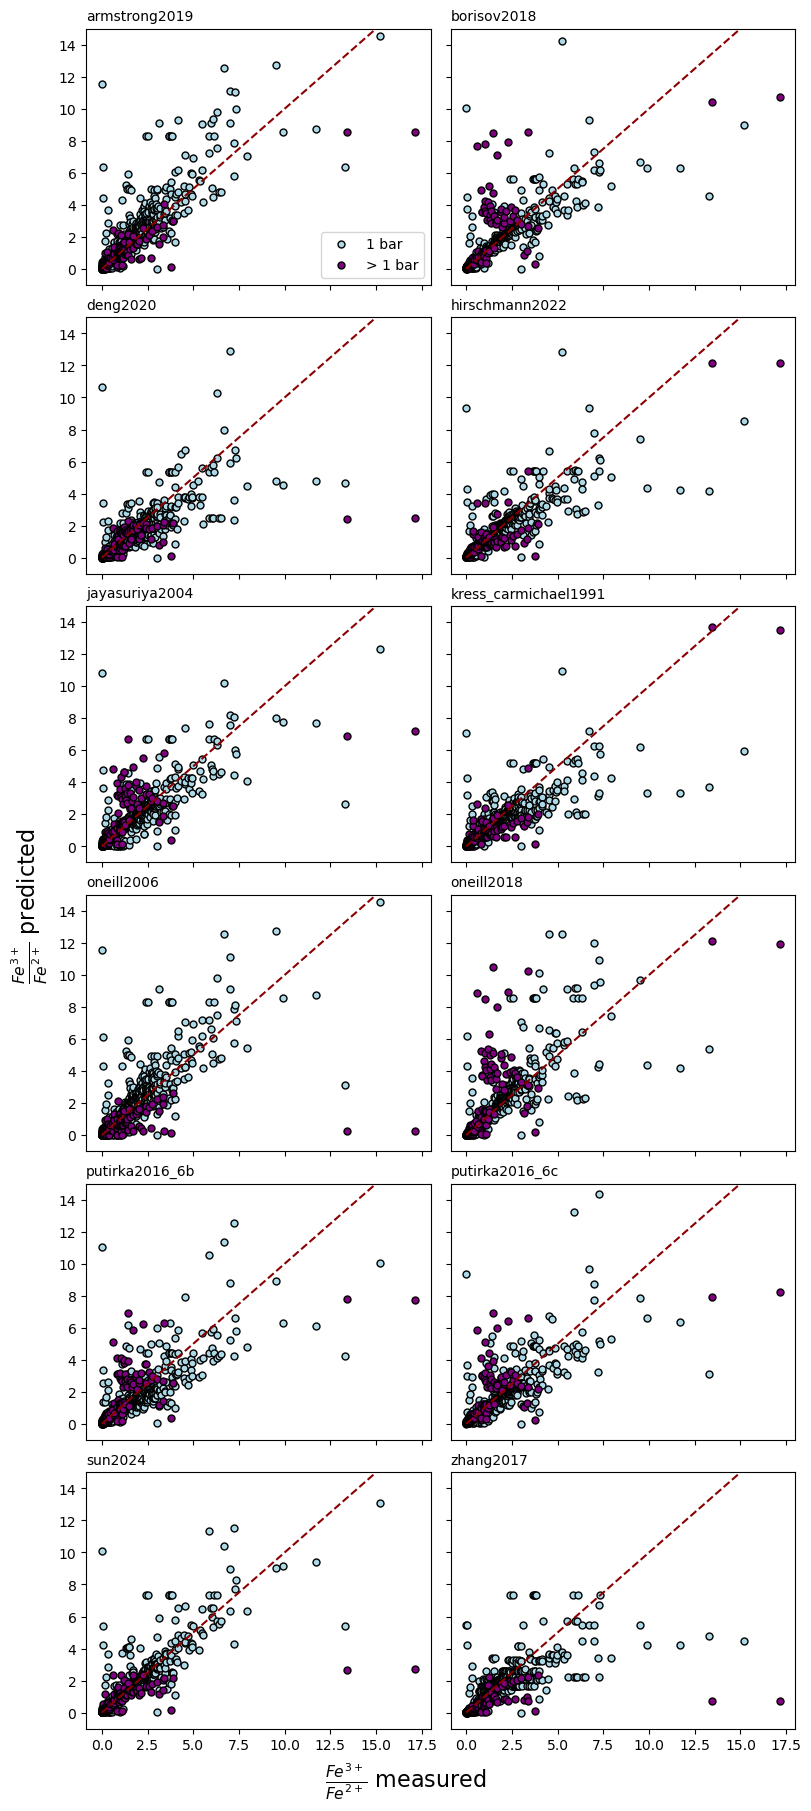

In [6]:
qry = ""
pressure_cutoff = 1

fig, axs = plt.subplots(6, 2, figsize=(8,18), sharex=True, sharey=True, constrained_layout=True)

x_max = data["_Fe3Fe2"].max()

for i, (name, d) in enumerate(results.items()):

    d_lp = d.query("(P_bar <= @pressure_cutoff) & (_Fe3Fe2 < 20)")
    d_hp = d.query("(P_bar > @pressure_cutoff) & (_Fe3Fe2 < 20)")

    for df, c, l in zip((d_lp, d_hp), ("lightblue", "purple"), ("1 bar", "> 1 bar")):  
    
        axs[i // 2, i % 2].plot(df["_Fe3Fe2"] , df["_Fe3Fe2_model"] , "o", mec="k", markersize=5, c=c, label=l)
        
    axs[i // 2, i % 2].plot([0, 15], [0, 15], "--", c="darkred", linewidth=1.5)
    axs[i // 2, i % 2].set_title(name, loc="left", size=10)


axs[0, 0].set_ylim(-1,15)
axs[0,0].legend()


fig.supxlabel("$\\frac{Fe^{3+}}{Fe^{2+}}$ measured", size=16)
fig.supylabel("$\\frac{Fe^{3+}}{Fe^{2+}}$ predicted", size=16)
plt.show()

Alternative plot showing model accuracies

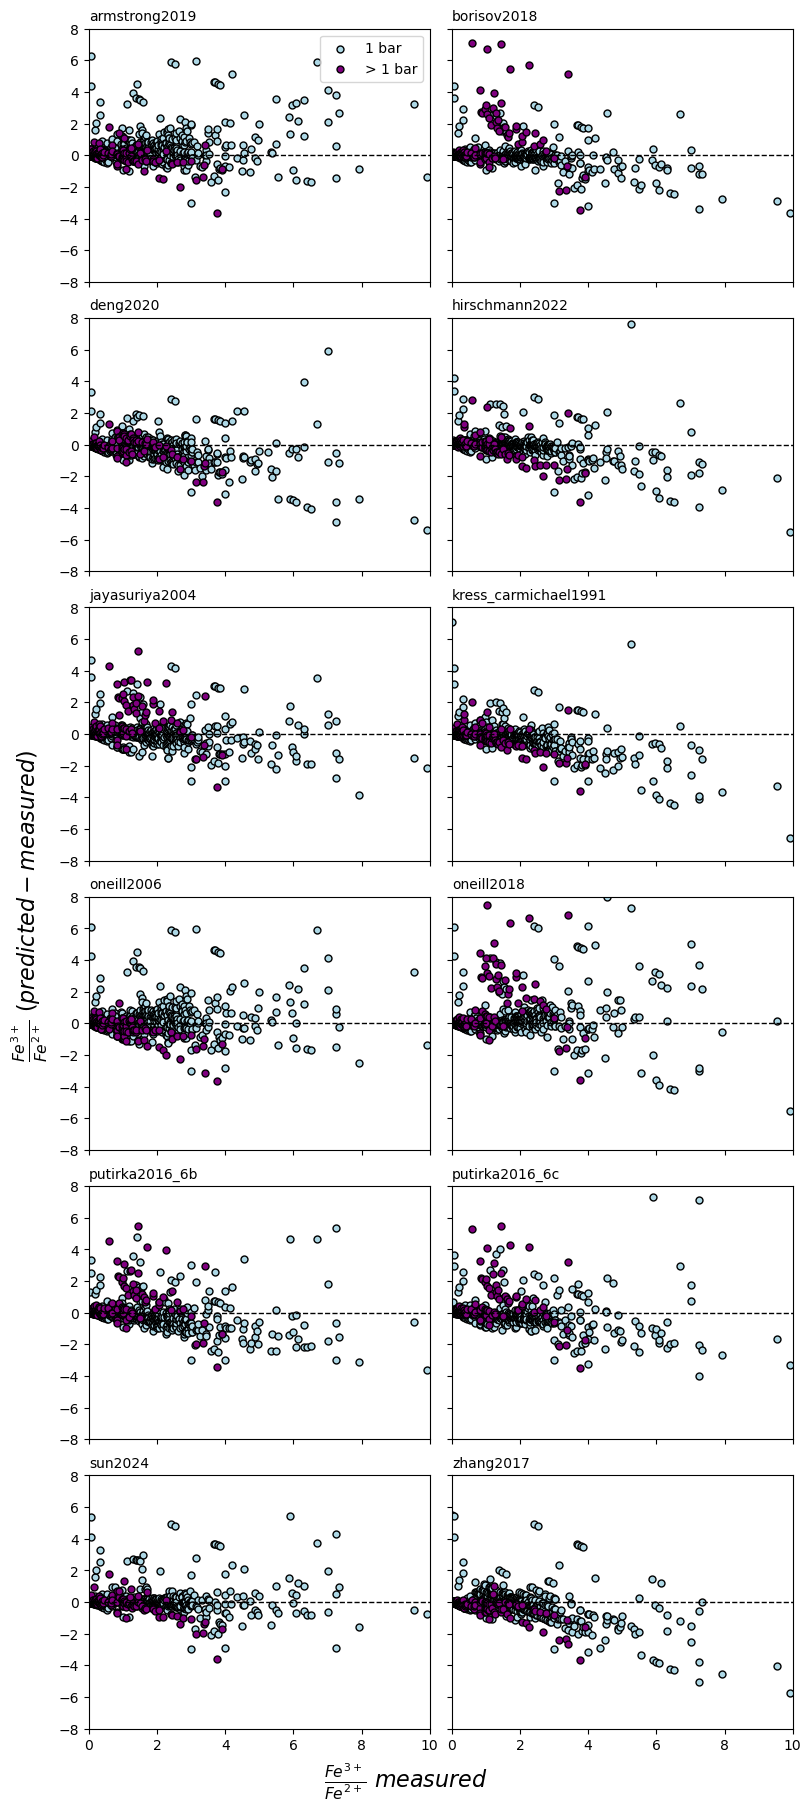

In [7]:
fig, axs = plt.subplots(6, 2, figsize=(8,18), sharey=True, sharex=True, constrained_layout=True)

for i, (name, d) in enumerate(results.items()):
    
    d_lp = d.query("P_bar <= @pressure_cutoff")
    d_hp = d.query("P_bar > @pressure_cutoff")


    for df, c, l in zip((d_lp, d_hp), ("lightblue", "purple"), ("1 bar", "> 1 bar")):        

        axs[i // 2, i % 2].scatter(df["_Fe3Fe2"], df["delta"], marker="o", ec="k", c=c, s=5**2, label=l)

    axs[i // 2, i % 2].axhline(y=0, linestyle="--", linewidth=1., c="k")
    axs[i // 2, i % 2].set_title(name, loc="left", size=10)    


axs[0,0].set_ylim(-8, 8)
axs[0,0].set_xlim(0, 10)
axs[0,0].legend()


fig.supylabel("$\\frac{Fe^{3+}}{Fe^{2+}}\ (predicted - measured)$", size=16)
fig.supxlabel("$\\frac{Fe^{3+}}{Fe^{2+}}\ measured$", size=16)

plt.show()



Plot showing model precision for experiments conducted at 1 bar. Precision is estimated from the standard deviation calculated in a moving window of 30 samples (i.e. the running standard deviation). Red lines show standard deviations in Fe3+/Fe2+ values (left y-axis) and green lines relative standard deviations are percentages (right y-axis). Both are plotted against the measured Fe3+/Fe2+ ratio on the x-axis. Both the absolute and relative standard deviations generally increase with measure Fe3+/Fe2+ ratios. We fitted mixed exponential + polynomial curves to the absolute standard deviations. The selected shapes for these curves are purely emperical. When [MagmaPEC](https://magmapec.readthedocs.io/en/latest/index.html) is run a 1 bar, it uses these curves to calculate errors during its error propagation model.

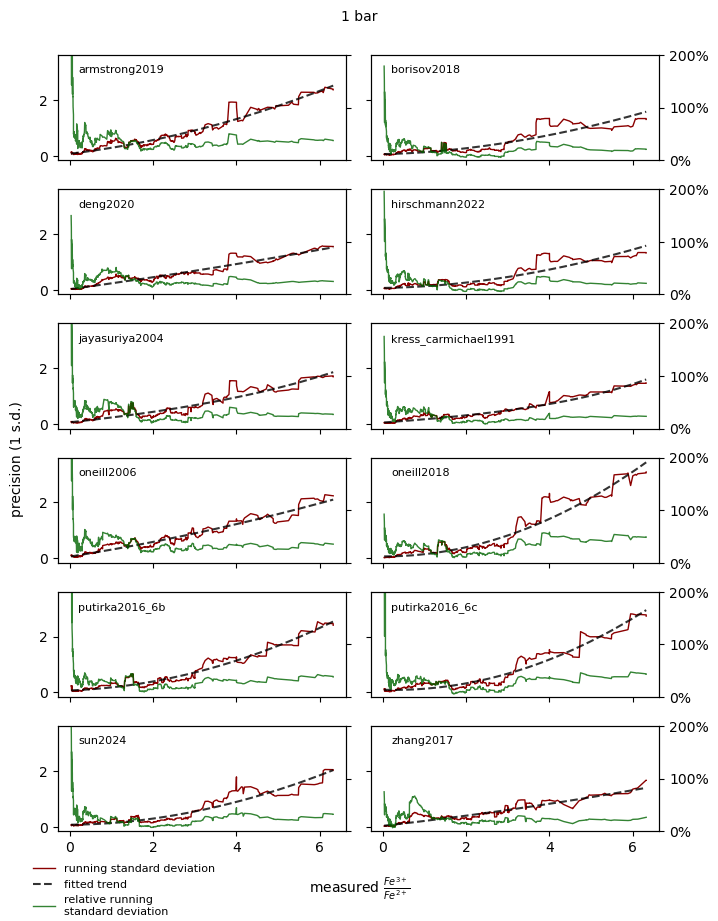

In [8]:
error_params = {}

mm = 1 / 25.4


from matplotlib.ticker import FuncFormatter

pressure_cutoff = 1

fig, axs = plt.subplots(6, 2, figsize=(185 * mm, 230 * mm), sharey=True, sharex=True, tight_layout=True)

sec_axs = np.empty(shape=axs.shape, dtype=axs.dtype)

for i, (name, d) in enumerate(results.items()):
    
    d_lp = d.query("P_bar <= @pressure_cutoff & (_Fe3Fe2 < 20)").sort_values("_Fe3Fe2")

    idx = d_lp["_Fe3Fe2_model"].dropna().index
    xvals, stddev = _running_stddev(d_lp.loc[idx, "_Fe3Fe2"], d_lp.loc[idx, "_Fe3Fe2_model"], boxsize=30)
    f_results = opt.curve_fit(f=_error_func, xdata=xvals, ydata=stddev, method="lm")
    error_params[name] = f_results[0]

    params = splrep(xvals, stddev, s=5)
    
    # axs[i // 2, i % 2].plot(d.query(qry)["_Fe3Fe2"] , d.query(qry)["_Fe3Fe2_model"] , "o", mec="k", markersize=3)
    axs[i // 2, i % 2].plot(xvals, stddev, "-", color="darkred", linewidth=1, label="running standard deviation")
    axs[i // 2, i % 2].plot(xvals, _error_func(xvals, *error_params[name]), "--", color="k", linewidth=1.5, alpha=0.8, label="fitted trend")
    
    # axs[i // 2, i % 2].plot(xvals, splev(xvals, params), "--", color="blue", linewidth=1.5, alpha=0.8)


    sec_axs[i // 2, i % 2] = axs[i // 2, i % 2].twinx()
    sec_axs[i // 2, i % 2].set_ylim(0,2)
    sec_axs[i // 2, i % 2].plot(xvals, stddev / xvals, "-", color="darkgreen", linewidth=1, alpha=0.8, label="relative running\nstandard deviation")

    

    axs[i // 2, i % 2].set_title(name, y=0.75, x=0.07, size=8, horizontalalignment="left")
    sec_axs[i // 2, i % 2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    if (i % 2) == 0:
        sec_axs[i // 2, i % 2].set_yticklabels([])

h1, l1 = axs[0, 0].get_legend_handles_labels()
h2, l2 = sec_axs[0, 0].get_legend_handles_labels()
h = h1 + h2
l = l1 + l2
fig.legend(h, l, prop={"size": 8}, loc=(0.04, 0.0), frameon=False)

label_size = 10
fig.supxlabel("measured $\\frac{Fe^{3+}}{Fe^{2+}}$", size=label_size)
fig.supylabel("precision (1 s.d.)", size=label_size)
fig.suptitle("1 bar",va='bottom', size=label_size)

plt.show()

Store fitted mixed exponential + polynomial functions to the 1 bar running standard deviations. Coefficients are printed below

In [9]:
for i, (name, d) in enumerate(results.items()):
    
    d = d.query("P_bar <= 1 & (_Fe3Fe2 < 20)").sort_values("_Fe3Fe2")
    idx = d["_Fe3Fe2_model"].dropna().index

    xvals, stddev = _running_stddev(d.loc[idx, "_Fe3Fe2"], d.loc[idx, "_Fe3Fe2_model"], boxsize=30)
    f_results = opt.curve_fit(f=_error_func, xdata=xvals, ydata=stddev, method="lm")
    error_params[name] = f_results[0]

    print(f"\n{name}:\n{(np.array(f_results[0]),)}")


armstrong2019:
(array([1.82181137e-01, 3.23457995e-02, 9.74520443e-01, 1.02125866e+02]),)

borisov2018:
(array([0.07314587, 0.027771  , 0.4342864 , 3.39615194]),)

deng2020:
(array([2.02752244e-01, 5.39532829e-03, 9.86195285e-01, 2.56507793e+02]),)

hirschmann2022:
(array([0.06085686, 0.02986529, 0.55588899, 4.50065524]),)

jayasuriya2004:
(array([ 0.13422863,  0.00863356,  1.44302139, -7.44449788]),)

kress_carmichael1991:
(array([ 7.98973259e-02,  4.30191610e-03,  1.55259523e+00, -6.51661370e+00]),)

oneill2006:
(array([2.36503606e-01, 1.36742572e-02, 9.84395668e-01, 1.78234429e+02]),)

oneill2018:
(array([0.01227881, 0.08359905, 0.73796086, 8.78940681]),)

putirka2016_6b:
(array([5.60555414e-02, 5.28947436e-02, 9.83790217e-01, 1.59595205e+02]),)

putirka2016_6c:
(array([-3.88599903e-02,  7.76443966e-02,  9.81141740e-01,  1.22593221e+02]),)

sun2024:
(array([0.04935861, 0.0426917 , 0.53606871, 4.26521912]),)

zhang2017:
(array([1.66423440e-01, 7.69701987e-03, 9.85045614e-01, 2.31563

Plot showing model precision in experimentes conducted at pressures > 1 bar. The total pressure range of the included samples is 0.2 - 28 GPa Precision is estimated from the standard deviation calculated in a moving window of 30 samples (i.e. the running standard deviation). Red lines show standard deviations in Fe3+/Fe2+ values (left y-axis) and green lines relative standard deviations are percentages (right y-axis). Both are plotted against the measured Fe3+/Fe2+ ratio on the x-axis. For most models, standard deviations do not show systematic trends with measured Fe3+/Fe2+ ratios. Instead, standard deviations trends are often curved and decrease after an initial increase. This is especially apparant in the models that have been calibrated exclusively at 1 bar ({cite:t}`borisov_ferricferrous_2018`, {cite:t}`Jayasuriya2004`, {cite:t}`Putirka2016` and {cite:t}`oneill_oxidation_2018`), and shows that they do not capture Fe3+/Fe2+ variations with pressure.



We fitted splines to the absolute standard deviations. When [MagmaPEC](https://magmapec.readthedocs.io/en/latest/index.html) is run at pressures > 1 bar, it uses these fitted curves to calculate errors during its error propagation model.

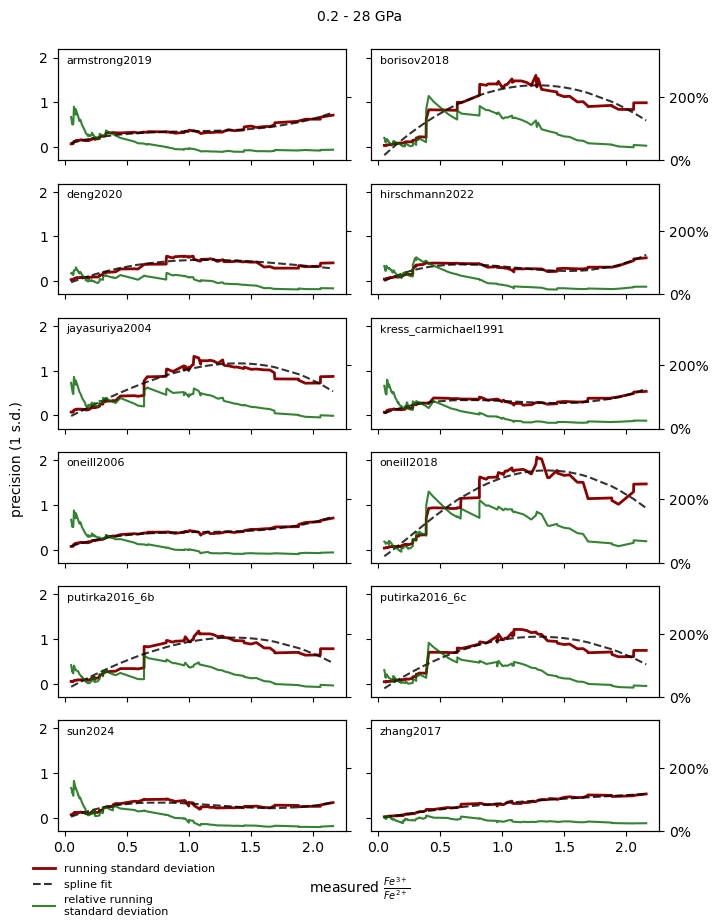

In [14]:
error_params = {}


from matplotlib.ticker import FuncFormatter

pressure_cutoff = 1

fig, axs = plt.subplots(6, 2, figsize=(185 * mm, 230 * mm), sharey=True, sharex=True, tight_layout=True)

sec_axs = np.empty(shape=axs.shape, dtype=axs.dtype)

for i, (name, d) in enumerate(results.items()):
    
    d_hp = d.query("P_bar > @pressure_cutoff").sort_values("_Fe3Fe2")

    idx = d_hp["_Fe3Fe2_model"].dropna().index
    
    xvals, stddev = _running_stddev(d_hp.loc[idx, "_Fe3Fe2"], d_hp.loc[idx, "_Fe3Fe2_model"], boxsize=30)

    weights = np.ones(len(xvals))
    # weights[0]=10
    params = splrep(xvals.values, stddev, w=weights, s=3)
    # f_results = opt.curve_fit(f=_error_func, xdata=xvals, ydata=stddev, method="lm")
    # error_params[name] = f_results[0]

    
    
    # axs[i // 2, i % 2].plot(d.query(qry)["_Fe3Fe2"] , d.query(qry)["_Fe3Fe2_model"] , "o", mec="k", markersize=3)
    axs[i // 2, i % 2].plot(xvals.values, stddev, "-", color="darkred", linewidth=2, label="running standard deviation")
    axs[i // 2, i % 2].plot(xvals.values, splev(xvals, params), "--", color="k", linewidth=1.5, alpha=0.8, label="spline fit")

    sec_axs[i // 2, i % 2] = axs[i // 2, i % 2].twinx()
    sec_axs[i // 2, i % 2].set_ylim(0,3.5)
    sec_axs[i // 2, i % 2].plot(xvals, stddev / xvals, "-", color="darkgreen", linewidth=1.5, alpha=0.8, label="relative running\nstandard deviation")

    axs[i // 2, i % 2].set_title(name, y=0.8, x=0.03, size=8, horizontalalignment="left")
    sec_axs[i // 2, i % 2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    if (i % 2) == 0:
        sec_axs[i // 2, i % 2].set_yticklabels([])


h1, l1 = axs[0, 0].get_legend_handles_labels()
h2, l2 = sec_axs[0, 0].get_legend_handles_labels()
h = h1 + h2
l = l1 + l2
fig.legend(h, l, prop={"size": 8}, loc=(0.04, 0.0), frameon=False)

label_size = 10
fig.supxlabel("measured $\\frac{Fe^{3+}}{Fe^{2+}}$", size=label_size)
fig.supylabel("precision (1 s.d.)", size=label_size)
fig.suptitle("0.2 - 28 GPa",va='bottom', size=label_size)

plt.show()

Store and print fited spline parameters

In [15]:
for i, (name, d) in enumerate(results.items()):
    
    d = d.query("P_bar > 1 & (_Fe3Fe2 < 20)").sort_values("_Fe3Fe2")
    idx = d["_Fe3Fe2_model"].dropna().index

    xvals, stddev = _running_stddev(d.loc[idx, "_Fe3Fe2"], d.loc[idx, "_Fe3Fe2_model"], boxsize=30)
    weights = np.ones(len(xvals))
    weights[0]=10

    print(f"\n{name}:\n{splrep(xvals, stddev, w=weights,s=3)}")


armstrong2019:
(array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 2.16064117,
       2.16064117, 2.16064117, 2.16064117]), array([0.07460737, 0.63155495, 0.03894889, 0.77937143, 0.        ,
       0.        , 0.        , 0.        ]), 3)

borisov2018:
(array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.59035243,
       2.16064117, 2.16064117, 2.16064117, 2.16064117]), array([0.00581678, 0.27693333, 1.48747235, 1.74215223, 0.50682697,
       0.        , 0.        , 0.        , 0.        ]), 3)

deng2020:
(array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 2.16064117,
       2.16064117, 2.16064117, 2.16064117]), array([0.02618869, 0.59716833, 0.57214722, 0.25797173, 0.        ,
       0.        , 0.        , 0.        ]), 3)

hirschmann2022:
(array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 2.16064117,
       2.16064117, 2.16064117, 2.16064117]), array([ 0.04061819,  0.87806539, -0.27681547,  0.57013273,  0.        ,
        0.        ,  0.        ,  0.        ]), 3